# Zone Analysis of EUA

For Radius = 150m

In [1]:
import numpy as np
import pandas as pd
import geopandas
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns

## Utility Function to Load EUA Data

In [34]:
#Add data to users
def add_data(series): #not used now
    random_speed = random.uniform(0,1)
    if random_speed <= 0.3:
        series['Speed']= 0
    if random_speed > 0.3 and random_speed <= 0.6:   
        series['Speed']= random.uniform(1, 2)
    if random_speed > 0.6:
        series['Speed'] = random.uniform(10, 20)
    series['Direction']= random.randrange(0, 360, 10)
    qospref = [ random.randint(1,3), random.randint(1,3) ]
    qospref.sort()
    series['LowQoS'] = qospref[0]
    series['HighQoS'] = qospref[1]
    return series

#===============User Data
def load_users(num_of_users):
    user_raw = pd.read_csv("users.csv")
    user_raw = user_raw.rename_axis("UID")
    df = user_raw.sample(num_of_users)
#     user_raw = user_raw.reset_index()
    gdf = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.Longitude, df.Latitude), crs = {'init': 'epsg:4326'})
    user = gdf [['geometry']] #Keep Geometry column
    user = user.to_crs(epsg=28355) #Covert the format of data
    #Insert additional data to dataframe
    #user = user.apply(add_data, axis=1)
    return user

#================Server Data
def load_servers(num_of_servers):
    server_raw = pd.read_csv("servers.csv")
    server_raw = server_raw.rename_axis("SID")
    df = server_raw.sample(num_of_servers) #Sample Servers Randomly
    gdf = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.LONGITUDE, df.LATITUDE), crs = {'init': 'epsg:4326'})
    server = gdf [['geometry']] #Keep Geometry column
    server = server.to_crs(epsg=28355) #Cover to crs in Australian EPSG
    def add_radius(series):
#         radius = random.randrange(150, 250, 10)
        radius = 150
        series.geometry = series.geometry.buffer(radius)
        series['radius'] = radius
#         series['resource'] = tcomp
        return series
    server = server.apply(add_radius, axis = 1)
    return server

#================neighbourhood Computing
def ngb_matrix(U, N): 
    #U: number of users
    #N: number of servers
    # U X N matrix
    user = load_users(U)
    server = load_servers(N)
    neighbourhood = np.zeros([U, N]) #matrix user(row) vs server(col)
    for u in range(0, U):
        for n in range(0, N):
            if server.iloc[n].geometry.contains(user.iloc[u].geometry):
                neighbourhood[u,n]=1
            else:
                neighbourhood[u,n]=0
    return neighbourhood, user, server

#Plot the user and server dataset on the map
def plot_data(user, server):
    %config InlineBackend.figure_format='retina'
    %matplotlib inline

    cbd = geopandas.read_file('maps', crs = {'init': 'epsg=28355'} ) #read cbd-australia location data

    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    ax.set_aspect('equal')

    ax.set_xlim(319400, 322100)
    ax.set_ylim(5811900, 5813700)

    user.plot(ax=ax, marker='o', color='red', markersize=20, zorder=3, label="users")
    server.plot(ax =ax, linestyle='dashed', edgecolor='green', linewidth=1, facecolor="none", zorder=1)
    server.centroid.plot(ax=ax, marker='s', color='blue', markersize=50, zorder=2, label="server")
    cbd.plot(ax=ax, color='grey', zorder=0, alpha = 0.3);

    ax.set_title("MEC Environment(EUA): CBD Melbourne(Australia)")
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left')
    plt.show()

User = 815 and server = 125 in original dataset

User max = 500 and Server max = 38 in filtered dataset

# Zone Calculation

In [3]:
U = 815 #Number of users
N = 125 #Number of Servers
ngb, user, server = ngb_matrix(U, N)

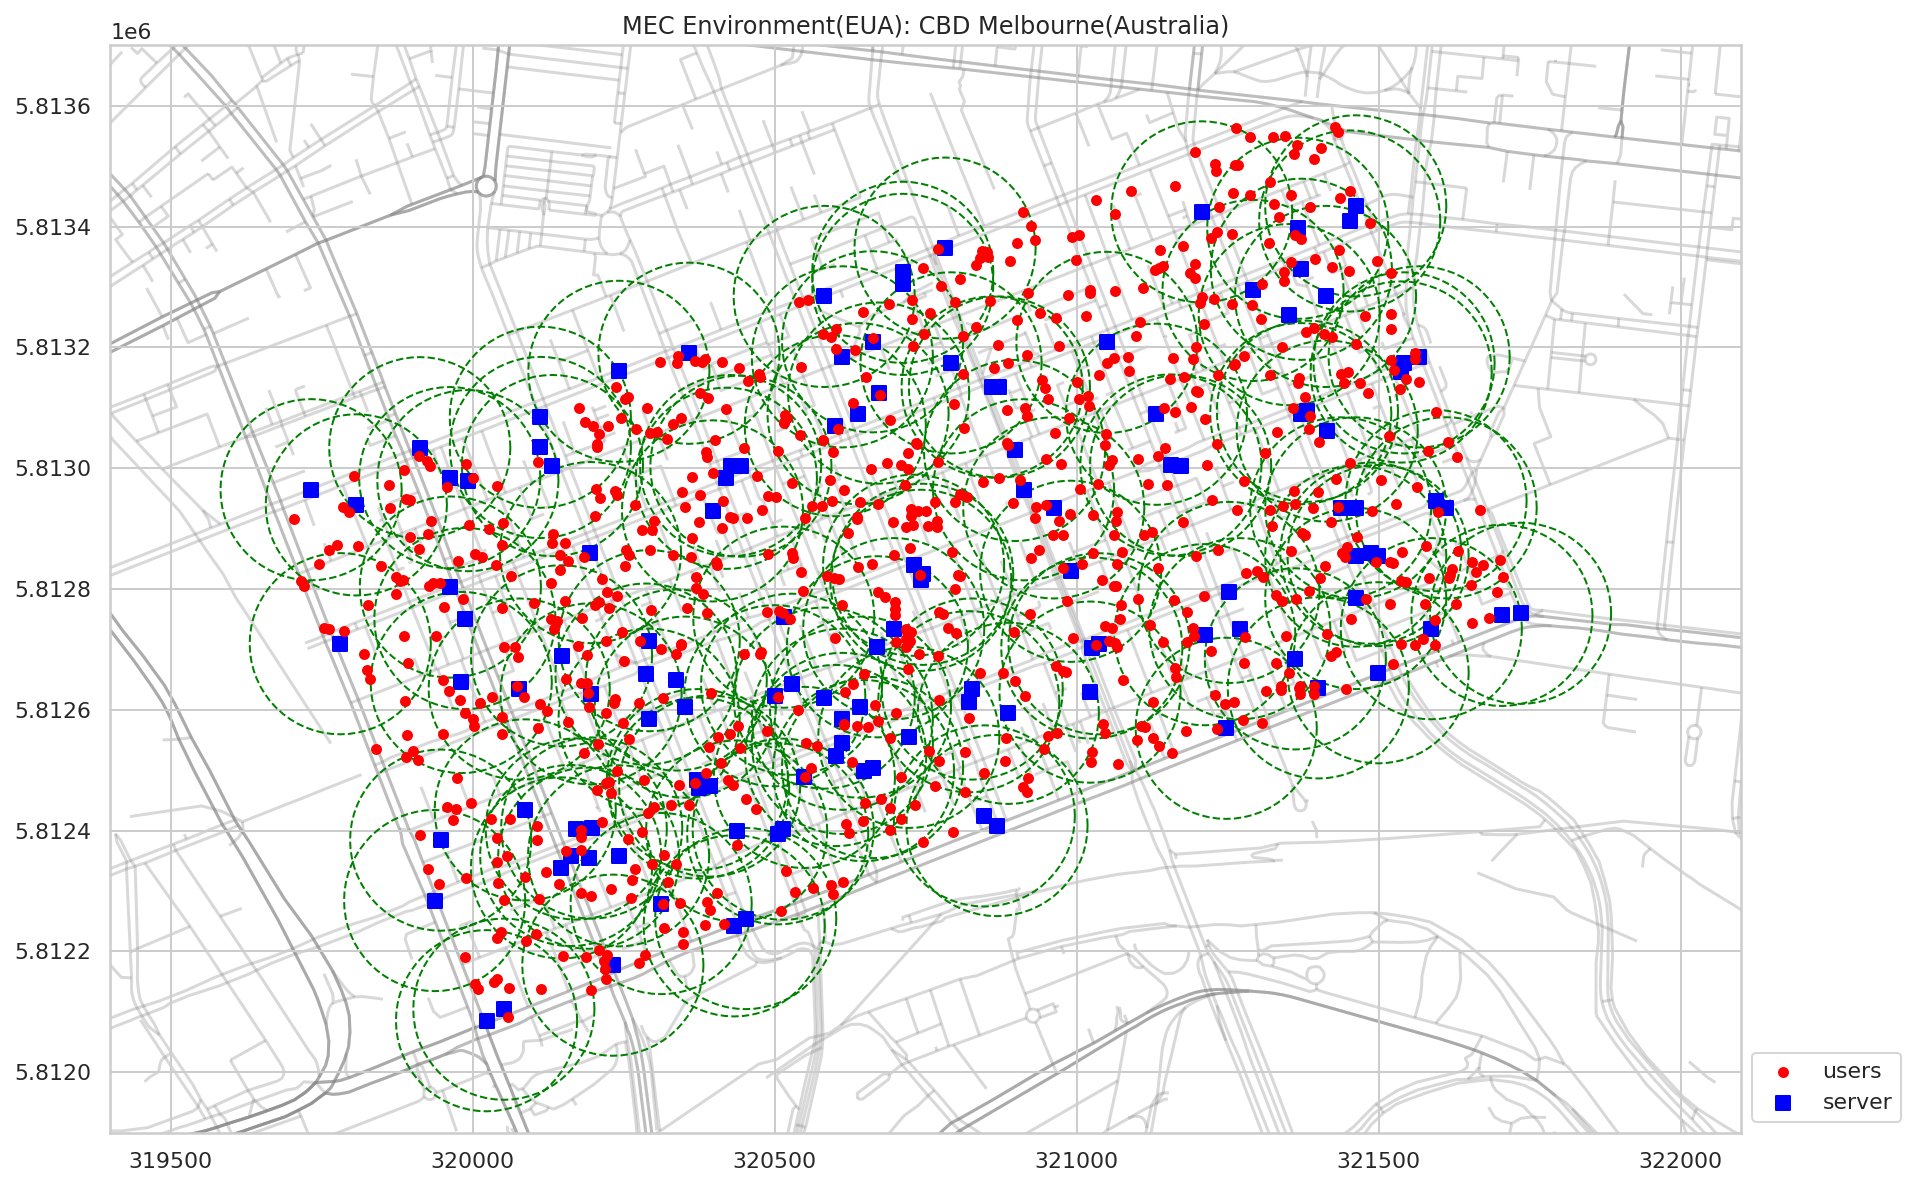

In [35]:
#plot data on map
plot_data(user, server)

In [5]:
class serverzone:
    def __init__(self, index):
        self.users = []
        self.num_of_servers = len(index)
        self.num_of_users = 0
        self.zone_info = index
        
    def add_user(self, user_index):
        self.users.append(user_index)
        self.num_of_users = len(self.users)
        
    def __str__(self):
        return "Zone:{}; Users: {}; Number of Users: {}".format(self.zone_info, self.users, self.num_of_users)
    
    def __repr__(self):
         return "Zone:{}; Users: {}; Number of Users: {}".format(self.zone_info, self.users, self.num_of_users)

In [6]:
h1_zones = {} #hierarchy of zones
#finding the number of zones, servers, user
# The tuple () contains users under no coverage area
total_zones = 0
max_server_in_zone = 0
for i in range(ngb.shape[0]):
    u_server = np.where(ngb[i] == 1)[0]

#     if len(u_server)==0:
#         continue #ignore users with no servers
    
    index = tuple(u_server) #list of servers as index for zone
    h1_index = len(index) #number of servers as index for heirarchy 1 zone
    
    if h1_index not in h1_zones:
        h1_zones[h1_index] = {}
        if h1_index > max_server_in_zone:
            max_server_in_zone = h1_index

        
    if index not in h1_zones[h1_index]:
        h1_zones[h1_index][index] = serverzone(index)
        total_zones += 1
    
    h1_zones[h1_index][index].add_user(i)

print( "Total Number of Zones:{}".format(total_zones-1) )
print( "Max Server in Zone:{}".format(max_server_in_zone) )    

Total Number of Zones:399
Max Server in Zone:12


In [7]:
h1_info = list(h1_zones.keys())
h1_info.sort() #sort the list with number of servers in a zone

#Plot server vs number of zones information
s_vs_z = []
s_vs_u = []
for h1_i in h1_info:
    if h1_i == 0: #skip users with no server
        continue
    s_vs_z.append( (h1_i, len(h1_zones[h1_i])) )
    
    for zn in h1_zones[h1_i]:
        s_vs_u.append( (h1_i, h1_zones[h1_i][zn].num_of_users) )

# Plots

<AxesSubplot:ylabel='NUmber of servers in Zone'>

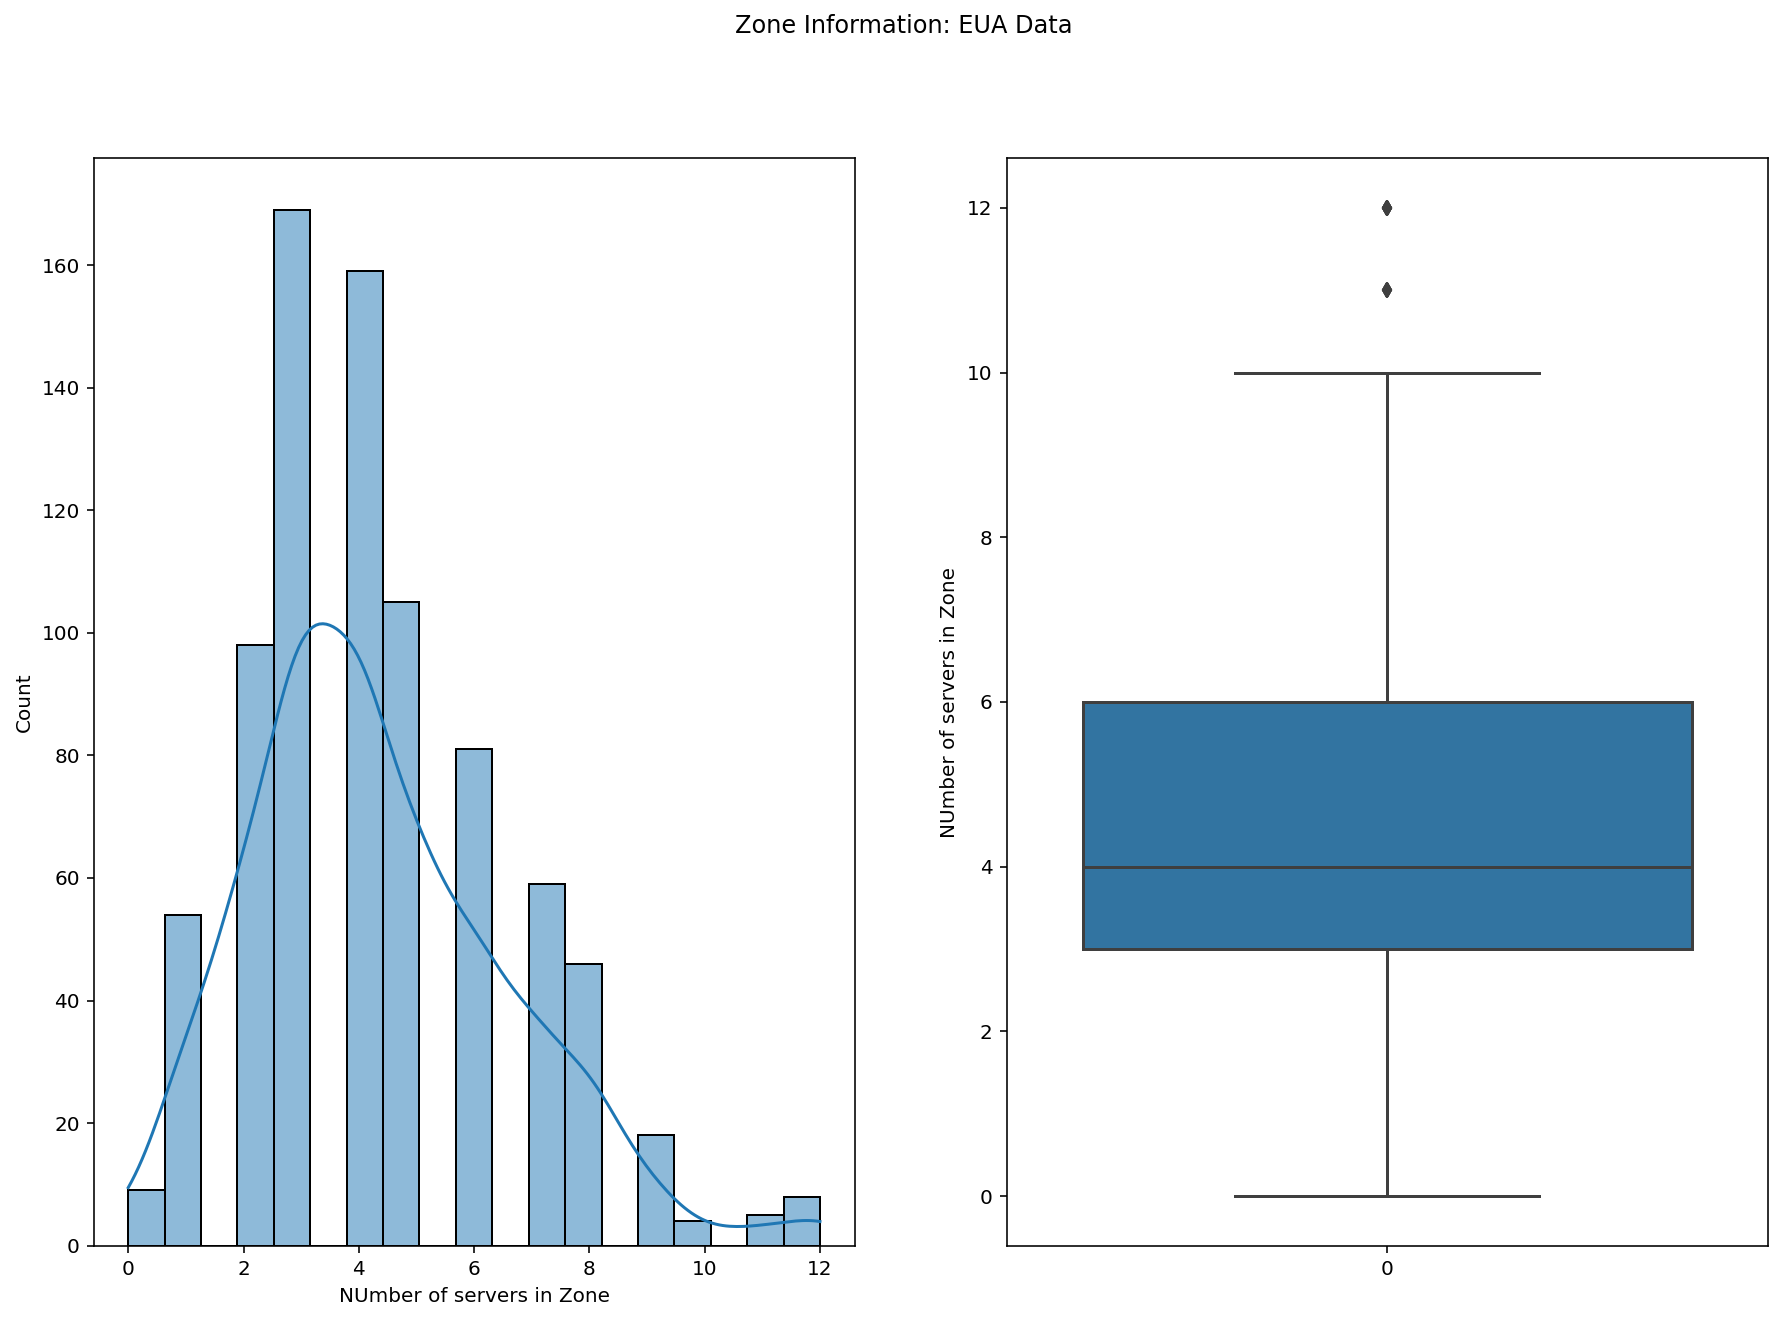

In [8]:
row_sum = ngb.sum(axis=1) #number of 
f, ax = plt.subplots(1, 2, figsize=(15,10))
f.suptitle("Zone Information: EUA Data")
sns.histplot(data = row_sum, kde=True, ax=ax[0])
ax[0].set_xlabel("NUmber of servers in Zone")
ax[1].set_ylabel("NUmber of servers in Zone")

sns.boxplot(data = row_sum, ax=ax[1])

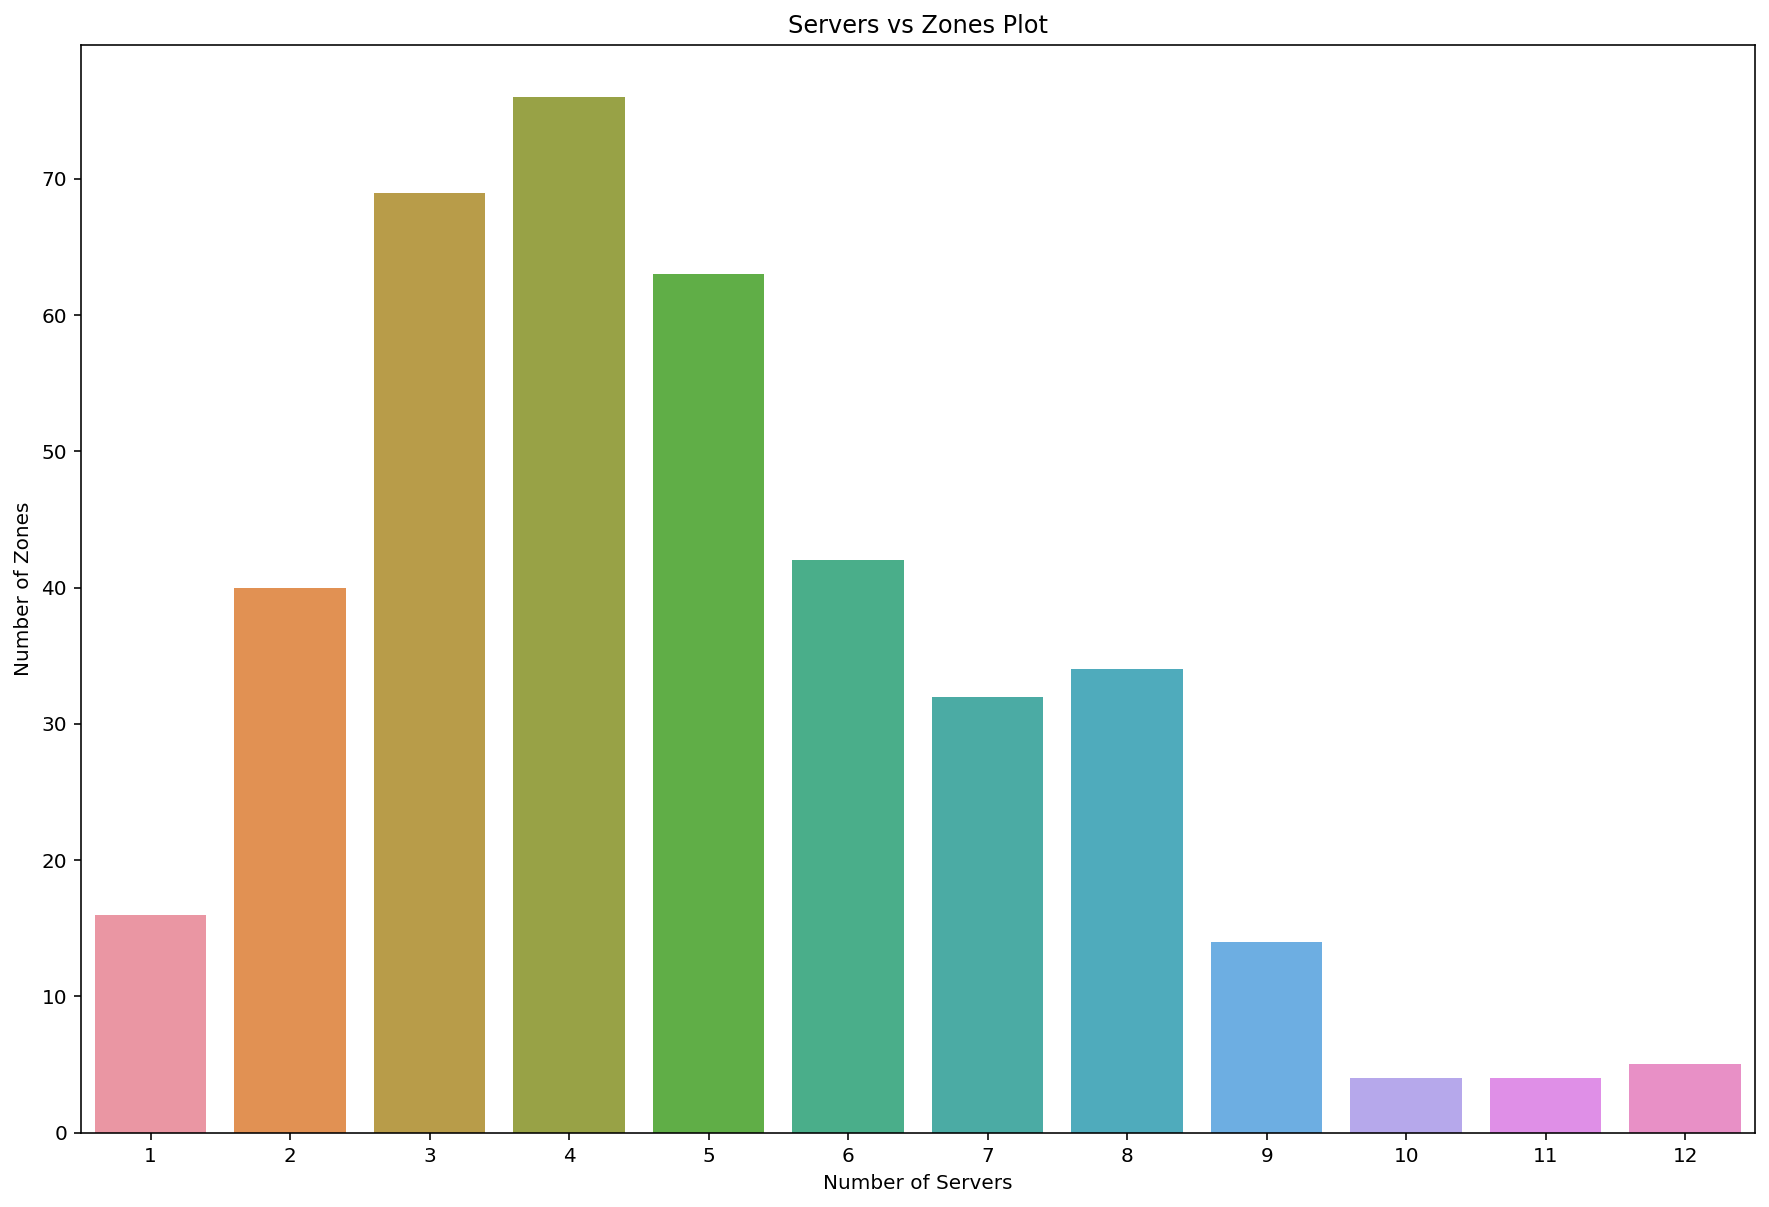

In [9]:
x,y = zip(*s_vs_z) 
fig1 = plt.figure(figsize = (15, 10))
 
# creating the bar plot
sns.barplot( x = list(x), y = list(y) )
 
plt.xlabel("Number of Servers")
plt.ylabel("Number of Zones")
plt.title("Servers vs Zones Plot")
plt.show()

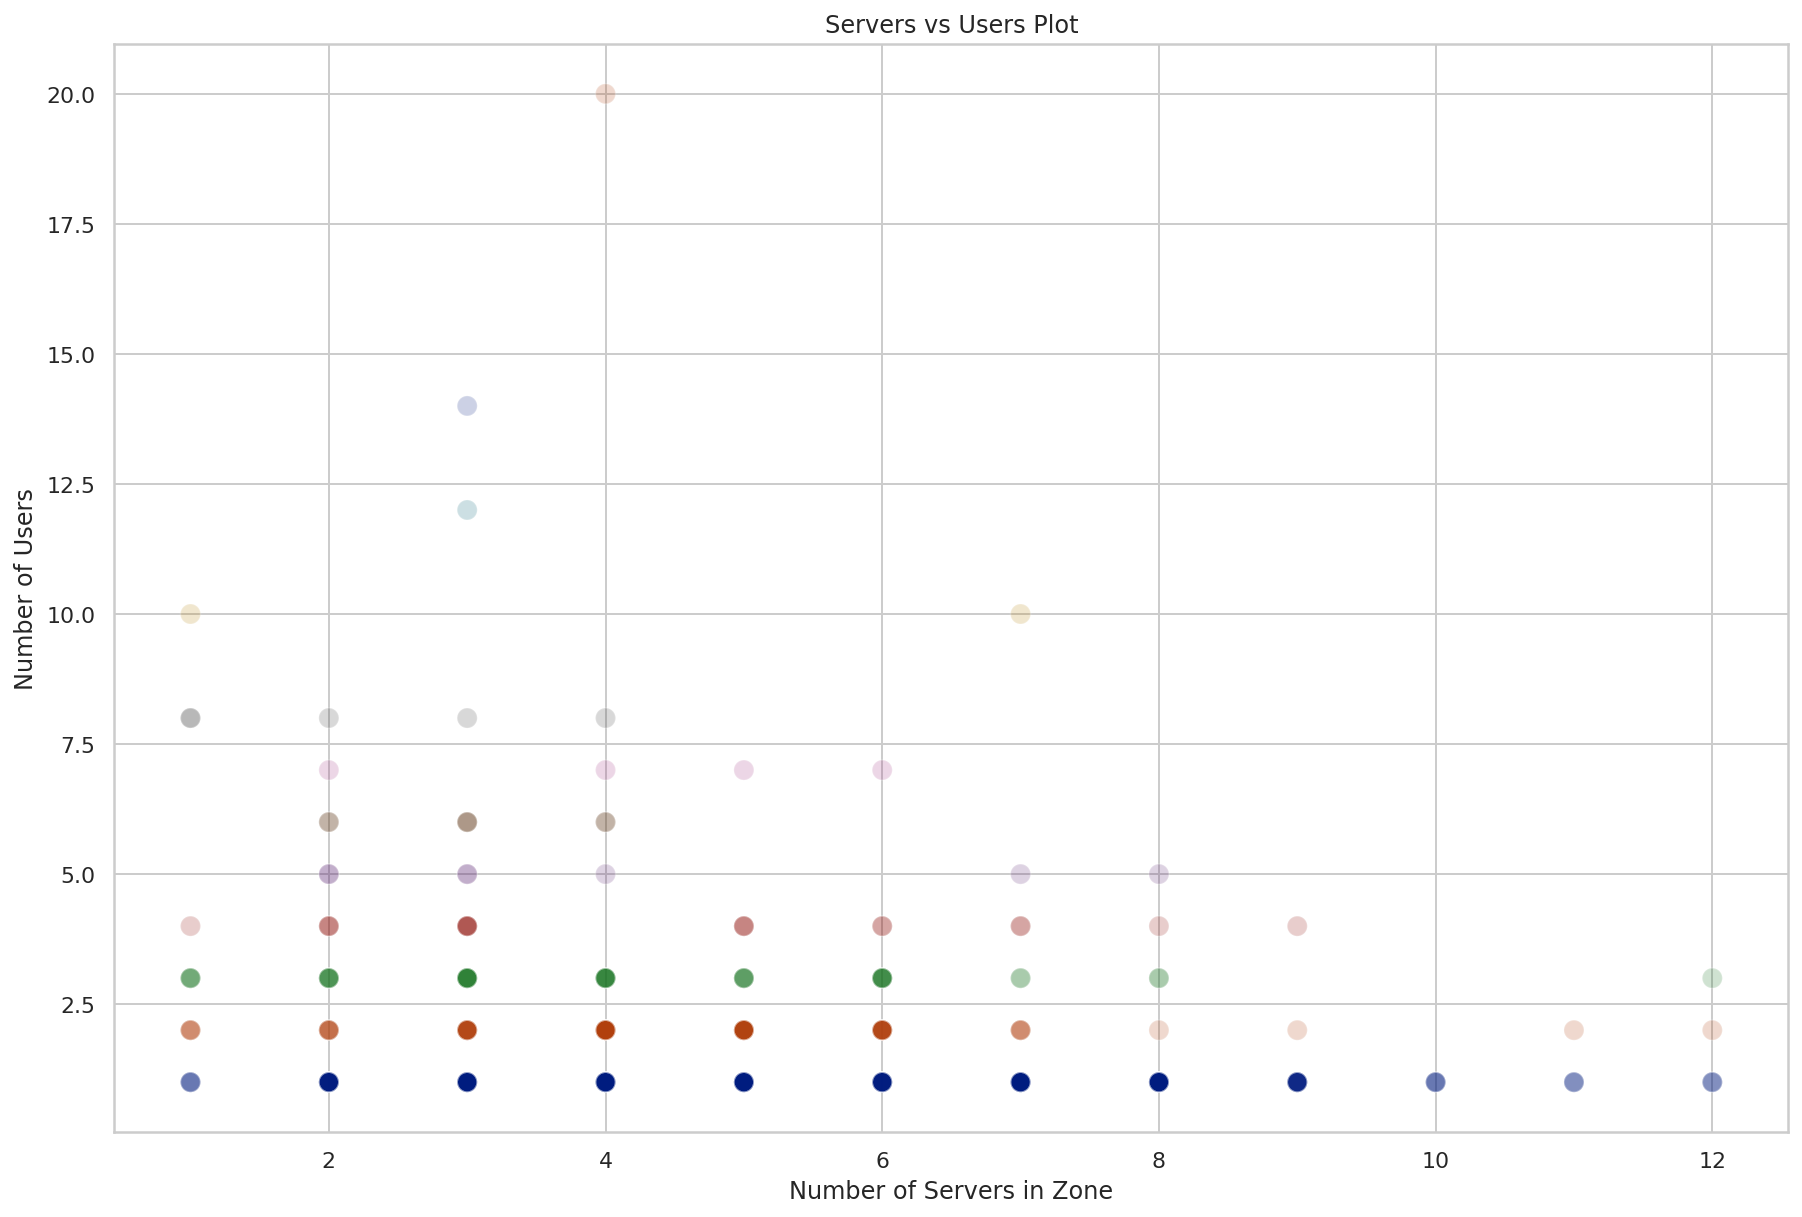

In [10]:
#scatter plot: num_server vs num_user
x,y = zip(*s_vs_u) 
fig2 = plt.figure(figsize = (15, 10))
sns.set(style='whitegrid')
sns.scatterplot(x=x, y=y, hue=y, palette="dark", legend=False, s=100, alpha=.2)
plt.xlabel("Number of Servers in Zone")
plt.ylabel("Number of Users")
plt.title("Servers vs Users Plot")
plt.show()

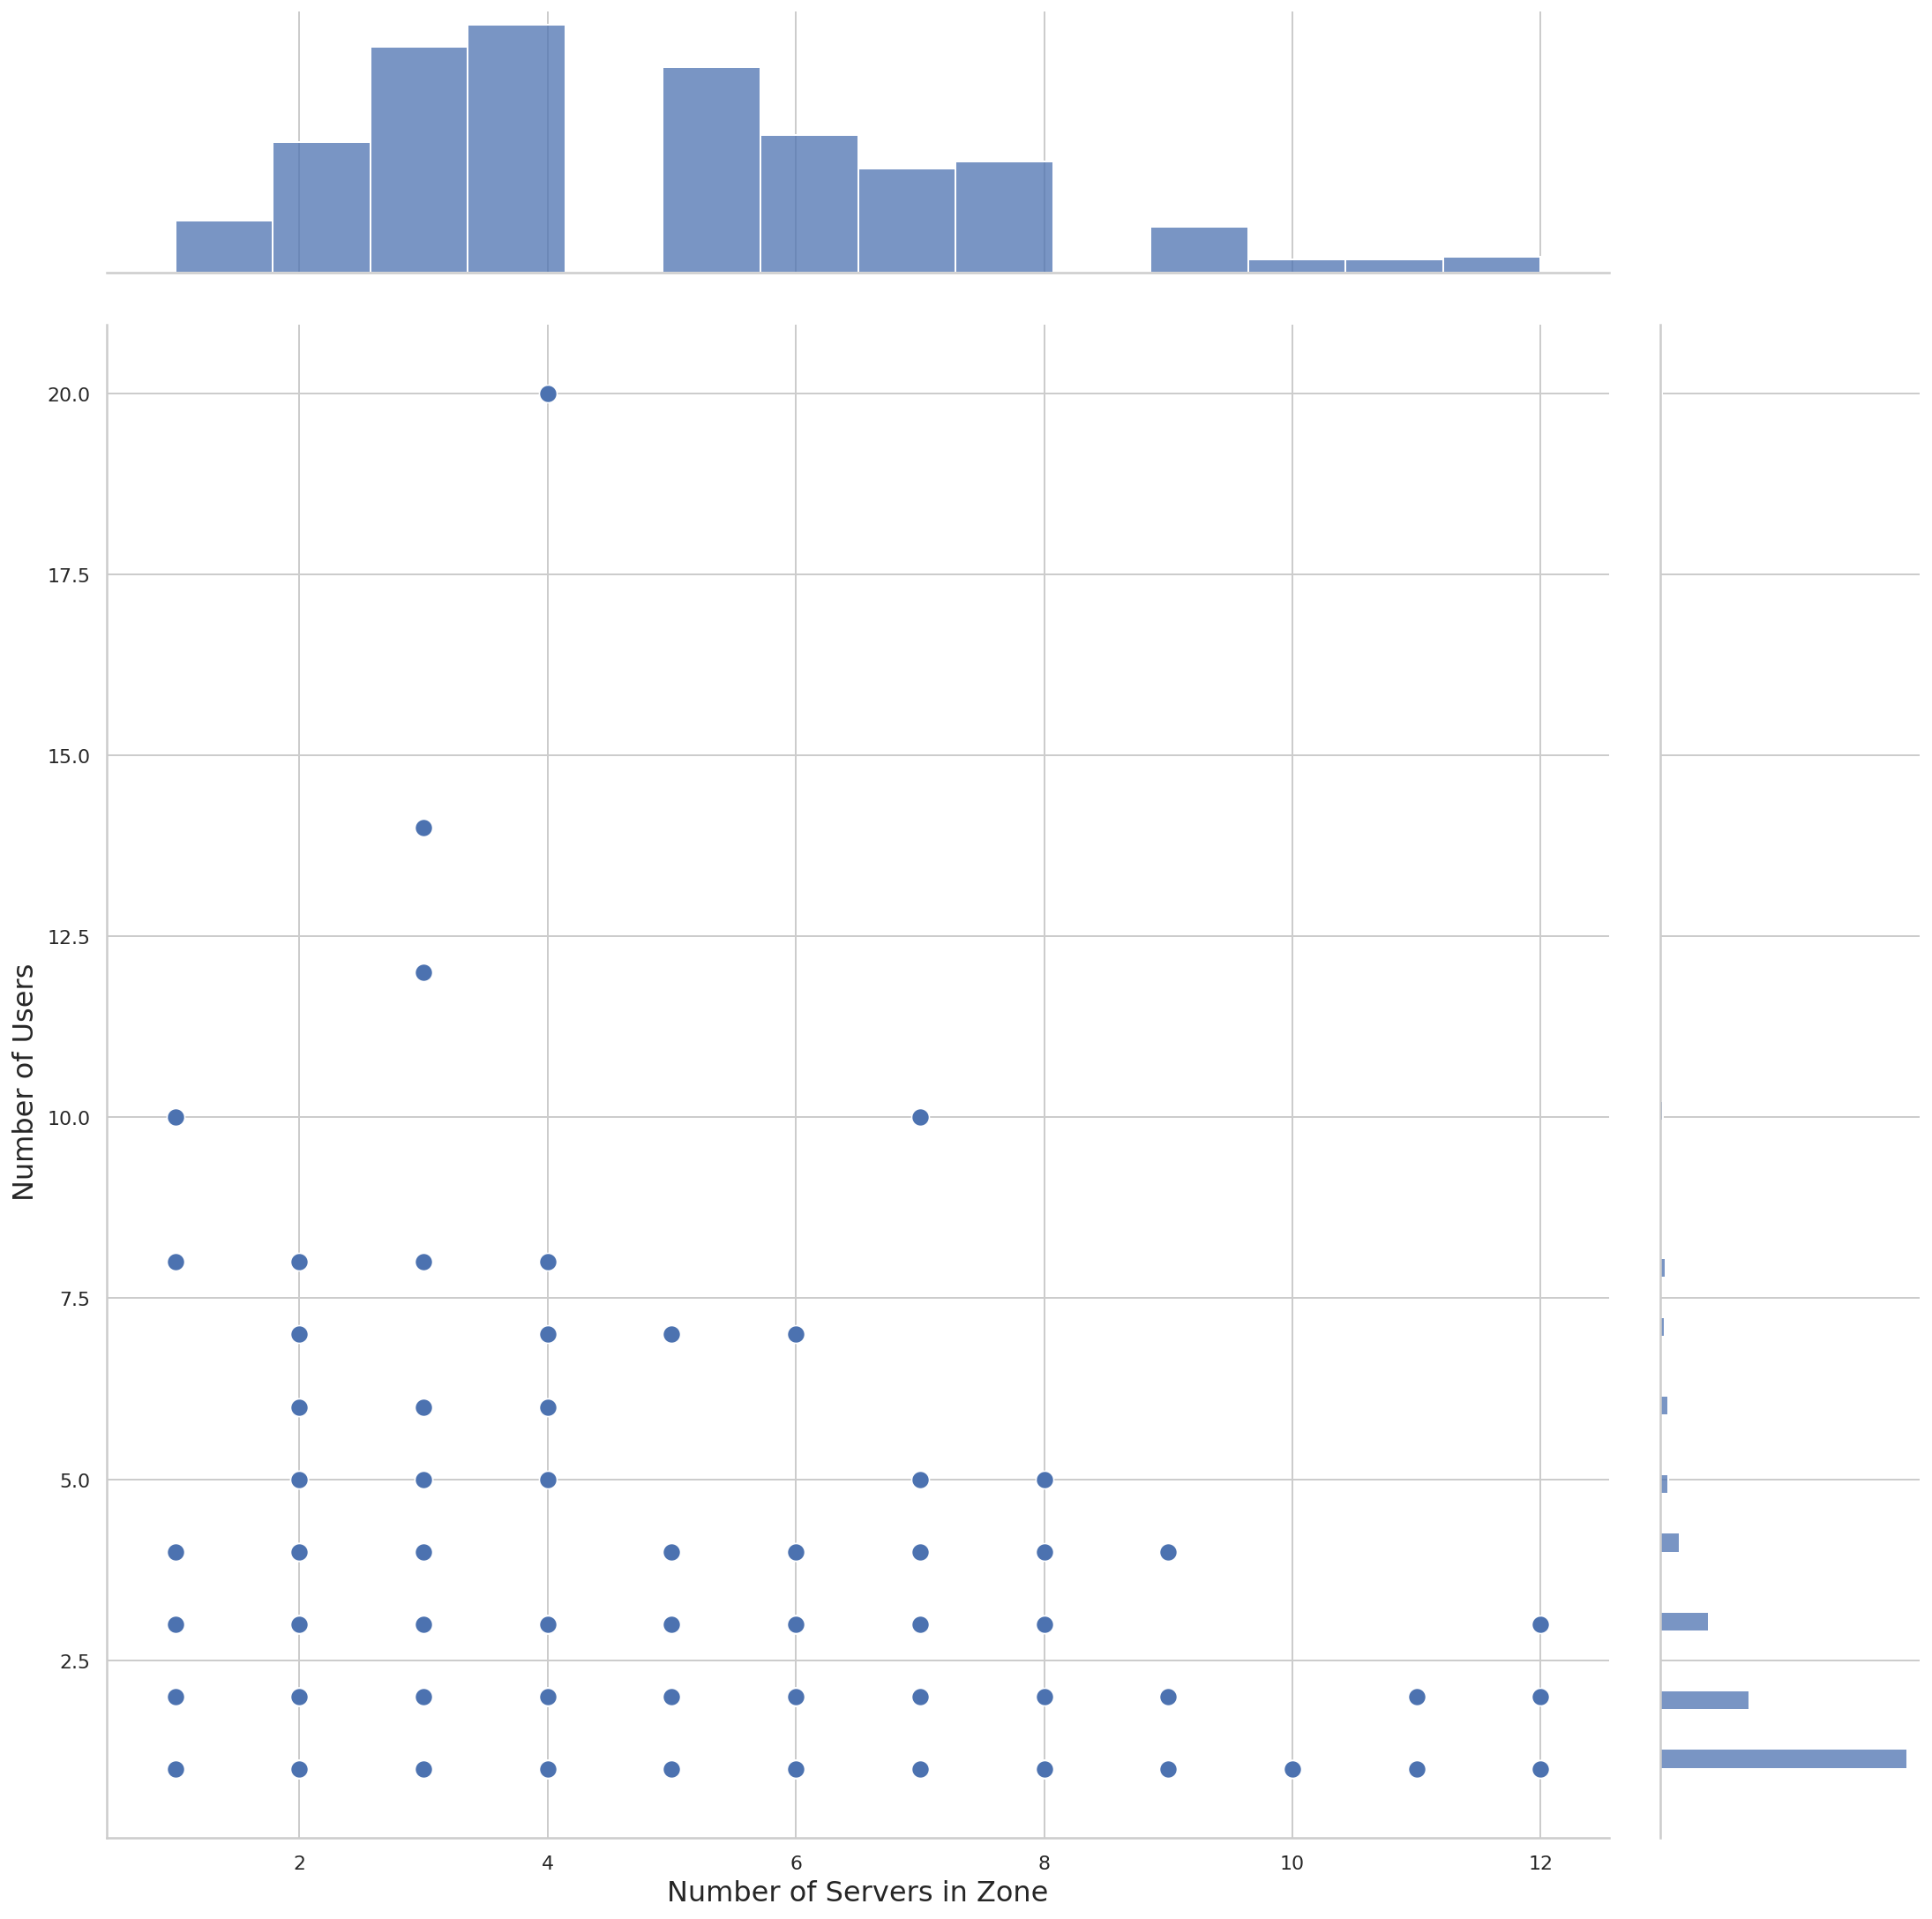

In [11]:
pl = sns.jointplot(x=x, y=y, height=15, s=100)
pl.set_axis_labels('Number of Servers in Zone', 'Number of Users', fontsize=16)

In [36]:
# h1_zones[12]